In [29]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    roc_curve,
    auc
)
from sklearn.preprocessing import label_binarize
import pandas as pd
import numpy as np
from itertools import cycle
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Read Arabic data
X_train_arabic = pd.read_csv("/kaggle/input/ahcd1/csvTrainImages 13440x1024.csv")
X_test_arabic = pd.read_csv("/kaggle/input/ahcd1/csvTestImages 3360x1024.csv")
Y_train_arabic = pd.read_csv("/kaggle/input/ahcd1/csvTrainLabel 13440x1.csv")
Y_test_arabic  = pd.read_csv("/kaggle/input/ahcd1/csvTestLabel 3360x1.csv")

# Check the shapes of the datasets
print("Shapes:")
print("X_train_arabic:", X_train_arabic.shape)
print("X_test_arabic:", X_test_arabic.shape)
print("Y_train_arabic:", Y_train_arabic.shape)
print("Y_test_arabic:", Y_test_arabic.shape)

Shapes:
X_train_arabic: (13439, 1024)
X_test_arabic: (3359, 1024)
Y_train_arabic: (13439, 1)
Y_test_arabic: (3359, 1)


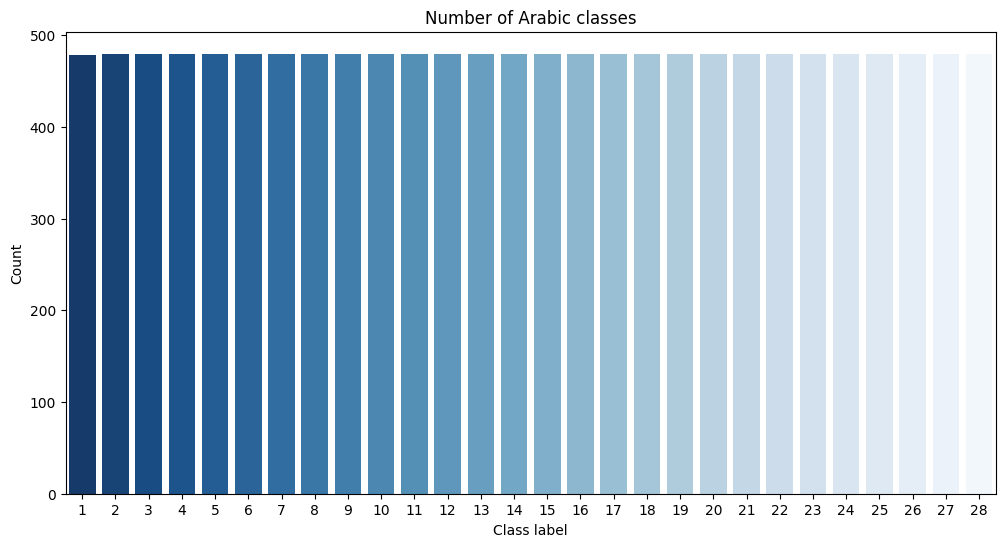

In [4]:
# Visualize the distribution of Arabic classes
# labels
y_labels_arabic = Y_train_arabic.iloc[:, 0]  # extract the first column

plt.figure(figsize=(12,6))

# Arabic classes
sns.countplot(x=y_labels_arabic, palette="Blues_r")
plt.title("Number of Arabic classes")
plt.xlabel("Class label")
plt.ylabel("Count")

plt.show()

In [5]:
# Data preprocessing

# Convert DataFrame → NumPy array
X_train_arabic = X_train_arabic.values.astype('float32')
X_test_arabic  = X_test_arabic.values.astype('float32')

# Reshape
X_train_arabic = X_train_arabic.reshape(-1, 32, 32, 1)
X_test_arabic  = X_test_arabic.reshape(-1, 32, 32, 1)

# Resize images to 96x96 
X_train_arabic = tf.image.resize(X_train_arabic, [96, 96]).numpy()
X_test_arabic = tf.image.resize(X_test_arabic, [96, 96]).numpy()

# Normalize
X_train = X_train_arabic / 255.0
X_test  = X_test_arabic / 255.0

# Labels → NumPy
Y_train = Y_train_arabic.values.flatten() - 1  # Convert to 0-indexed
Y_test = Y_test_arabic.values.flatten() - 1

# Check for any invalid labels
print(f"\nLabel range - Train: [{Y_train.min()}, {Y_train.max()}]")
print(f"Label range - Test: [{Y_test.min()}, {Y_test.max()}]")

num_classes = 28

print("\nProcessed Shapes:")
print(f"X_train: {X_train.shape}")
print(f"X_test: {X_test.shape}")
print(f"Y_train: {Y_train.shape}")
print(f"Y_test: {Y_test.shape}")


I0000 00:00:1765330400.440240      47 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0



Label range - Train: [0, 27]
Label range - Test: [0, 27]

Processed Shapes:
X_train: (13439, 96, 96, 1)
X_test: (3359, 96, 96, 1)
Y_train: (13439,)
Y_test: (3359,)


In [6]:
# DATA AUGMENTATION 
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    shear_range=0.1,
    fill_mode='nearest'
)
datagen.fit(X_train)

# **VGG-19 MODEL**
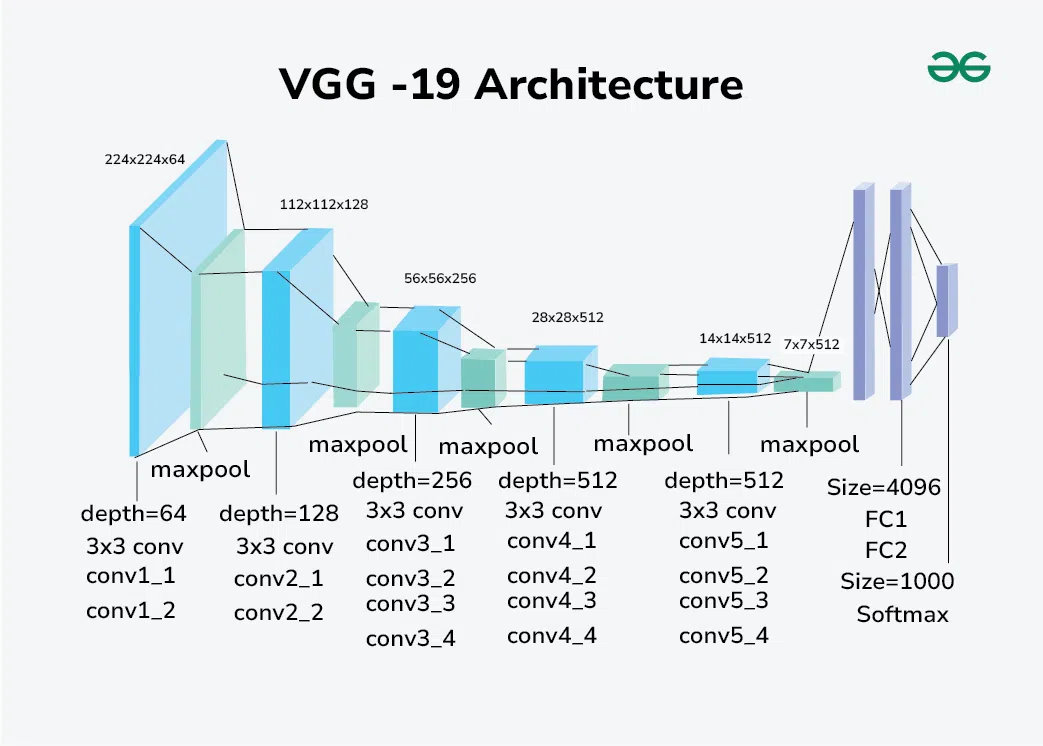
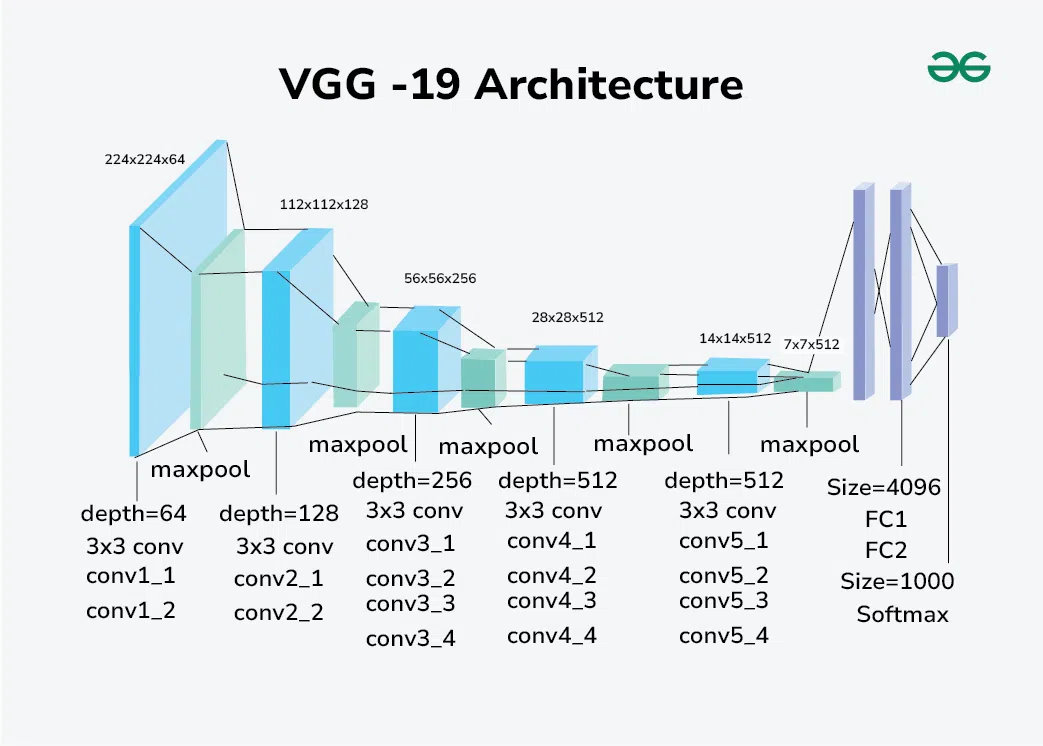

In [9]:
# VGG-19 MODEL
def create_vgg19_model(input_shape=(96, 96, 1), num_classes=28):
    
    model = Sequential(name='VGG19_Arabic')
    
    # Block 1
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same', input_shape=input_shape))
    model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Block 2
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.25))
    
    # Block 3
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(256, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Block 4
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    # Block 5
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(Conv2D(512, (3, 3), activation='relu', padding='same'))
    model.add(BatchNormalization())
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.4))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(4096, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    model.add(Dense(num_classes, activation='softmax'))
    
    return model

model = create_vgg19_model(input_shape=(96, 96, 1), num_classes=num_classes)

# Compile model with sparse categorical crossentropy
optimizer = Adam(learning_rate=0.001)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model summary
model.summary()

# CALLBACKS 
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

# Early stopping to prevent overfitting
early_stop = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    verbose=1
)

# Save best model
checkpoint = ModelCheckpoint(
    'best_vgg19_arabic.keras',
    monitor='val_accuracy',
    save_best_only=True,
    mode='max',
    verbose=1
)

callbacks = [reduce_lr, early_stop, checkpoint]

# TRAIN THE MODEL 

batch_size = 64
epochs = 30

history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=batch_size),
    epochs=epochs,
    validation_data=(X_test, Y_test),
    callbacks=callbacks,
    verbose=1
)

Model: "VGG19_Arabic"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_32 (Conv2D)              │ (None, 96, 96, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_33 (Conv2D)              │ (None, 96, 96, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 96, 96, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_14 (Dropout)            │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_34 (Conv2D)              │ (None, 48, 48, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_35 (Conv2D)              │ (None, 48, 48, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_15          │ (None, 48, 48, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_15 (Dropout)            │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_36 (Conv2D)              │ (None, 24, 24, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_37 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_38 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_39 (Conv2D)              │ (None, 24, 24, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_16          │ (None, 24, 24, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 12, 12, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_40 (Conv2D)              │ (None, 12, 12, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_41 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_42 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_43 (Conv2D)              │ (None, 12, 12, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_17          │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 6, 6, 512)      │             

 Total params: 55,836,380 (213.00 MB)

 Trainable params: 55,817,052 (212.93 MB)

 Non-trainable params: 19,328 (75.50 KB)

Epoch 1/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 169ms/step - accuracy: 0.1116 - loss: 4.2217
Epoch 1: val_accuracy improved from -inf to 0.03543, saving model to best_vgg19_arabic.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 58s 205ms/step - accuracy: 0.1119 - loss: 4.2187 - val_accuracy: 0.0354 - val_loss: 23.5549 - learning_rate: 0.0010
Epoch 2/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.3119 - loss: 2.5086
Epoch 2: val_accuracy did not improve from 0.03543
210/210 ━━━━━━━━━━━━━━━━━━━━ 30s 142ms/step - accuracy: 0.3120 - loss: 2.5080 - val_accuracy: 0.0354 - val_loss: 37.3265 - learning_rate: 0.0010
Epoch 3/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accuracy: 0.4845 - loss: 1.7696
Epoch 3: val_accuracy improved from 0.03543 to 0.16940, saving model to best_vgg19_arabic.keras
210/210 ━━━━━━━━━━━━━━━━━━━━ 33s 157ms/step - accuracy: 0.4847 - loss: 1.7690 - val_accuracy: 0.1694 - val_loss: 8.3601 - learning_rate: 0.0010
Epoch 4/30
210/210 ━━━━━━━━━━━━━━━━━━━━ 0s 131ms/step - accura

In [10]:
# Calculate test loss and accuracy
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=0)
print(f"\nTest Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")


Test Loss: 0.0901
Test Accuracy: 97.83%


In [11]:
# Generate Predictions
Y_pred_probs = model.predict(X_test, verbose=0)
Y_pred_classes = np.argmax(Y_pred_probs, axis=1)

In [15]:
# Calculate precision, recall, and F1-score
precision = precision_score(Y_test, Y_pred_classes, average='weighted')
recall = recall_score(Y_test, Y_pred_classes, average='weighted')
f1 = f1_score(Y_test, Y_pred_classes, average='weighted')

print(f"\nAccuracy:  {test_accuracy*100:.2f}%")
print(f"Precision: {precision*100:.2f}%")
print(f"Recall:    {recall*100:.2f}%")
print(f"F1-Score:  {f1*100:.2f}%")


Accuracy:  97.83%
Precision: 97.87%
Recall:    97.83%
F1-Score:  97.83%


In [19]:
from sklearn.metrics import classification_report

# class names
class_names = ['أ', 'ب', 'ت', 'ث', 'ج', 'ح', 'خ', 'د', 'ذ', 'ر',
               'ز', 'س', 'ش', 'ص', 'ض', 'ط', 'ظ', 'ع', 'غ', 'ف',
               'ق', 'ك', 'ل', 'م', 'ن', 'هـ', 'و', 'ي']

# classification report
report = classification_report(Y_test, Y_pred_classes, target_names=class_names)
print("CLASSIFICATION REPORT")
print("="*70)
print(report)

CLASSIFICATION REPORT
              precision    recall  f1-score   support

           أ       0.98      1.00      0.99       119
           ب       1.00      0.99      1.00       120
           ت       0.94      0.96      0.95       120
           ث       0.98      0.97      0.97       120
           ج       0.98      0.99      0.99       120
           ح       0.97      0.99      0.98       120
           خ       0.99      0.98      0.99       120
           د       0.97      0.95      0.96       120
           ذ       0.97      0.96      0.96       120
           ر       0.92      1.00      0.96       120
           ز       0.98      0.94      0.96       120
           س       0.98      1.00      0.99       120
           ش       0.98      1.00      0.99       120
           ص       0.98      0.98      0.98       120
           ض       0.98      0.95      0.97       120
           ط       0.96      1.00      0.98       120
           ظ       1.00      0.95      0.97       120
     

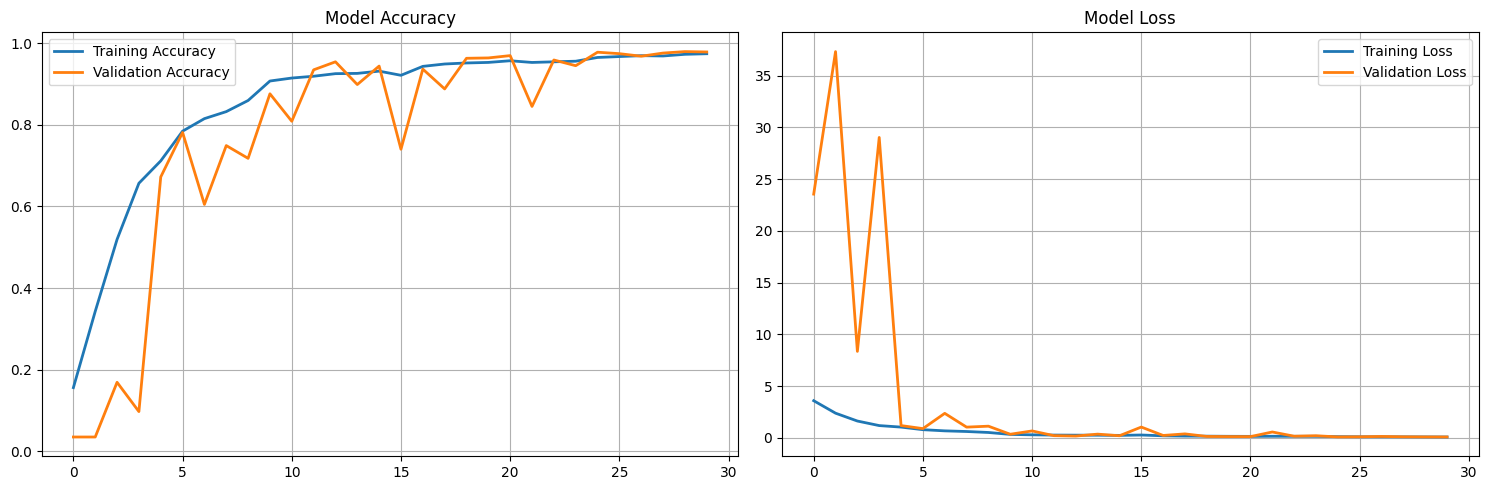

In [17]:
# Plot training and validation accuracy/loss
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Accuracy
axes[0].plot(history.history['accuracy'], label='Training Accuracy', linewidth=2)
axes[0].plot(history.history['val_accuracy'], label='Validation Accuracy', linewidth=2)
axes[0].set_title('Model Accuracy')
axes[0].legend()
axes[0].grid(True)

# Loss
axes[1].plot(history.history['loss'], label='Training Loss', linewidth=2)
axes[1].plot(history.history['val_loss'], label='Validation Loss', linewidth=2)
axes[1].set_title('Model Loss')
axes[1].legend()
axes[1].grid(True)

plt.tight_layout()
plt.show()

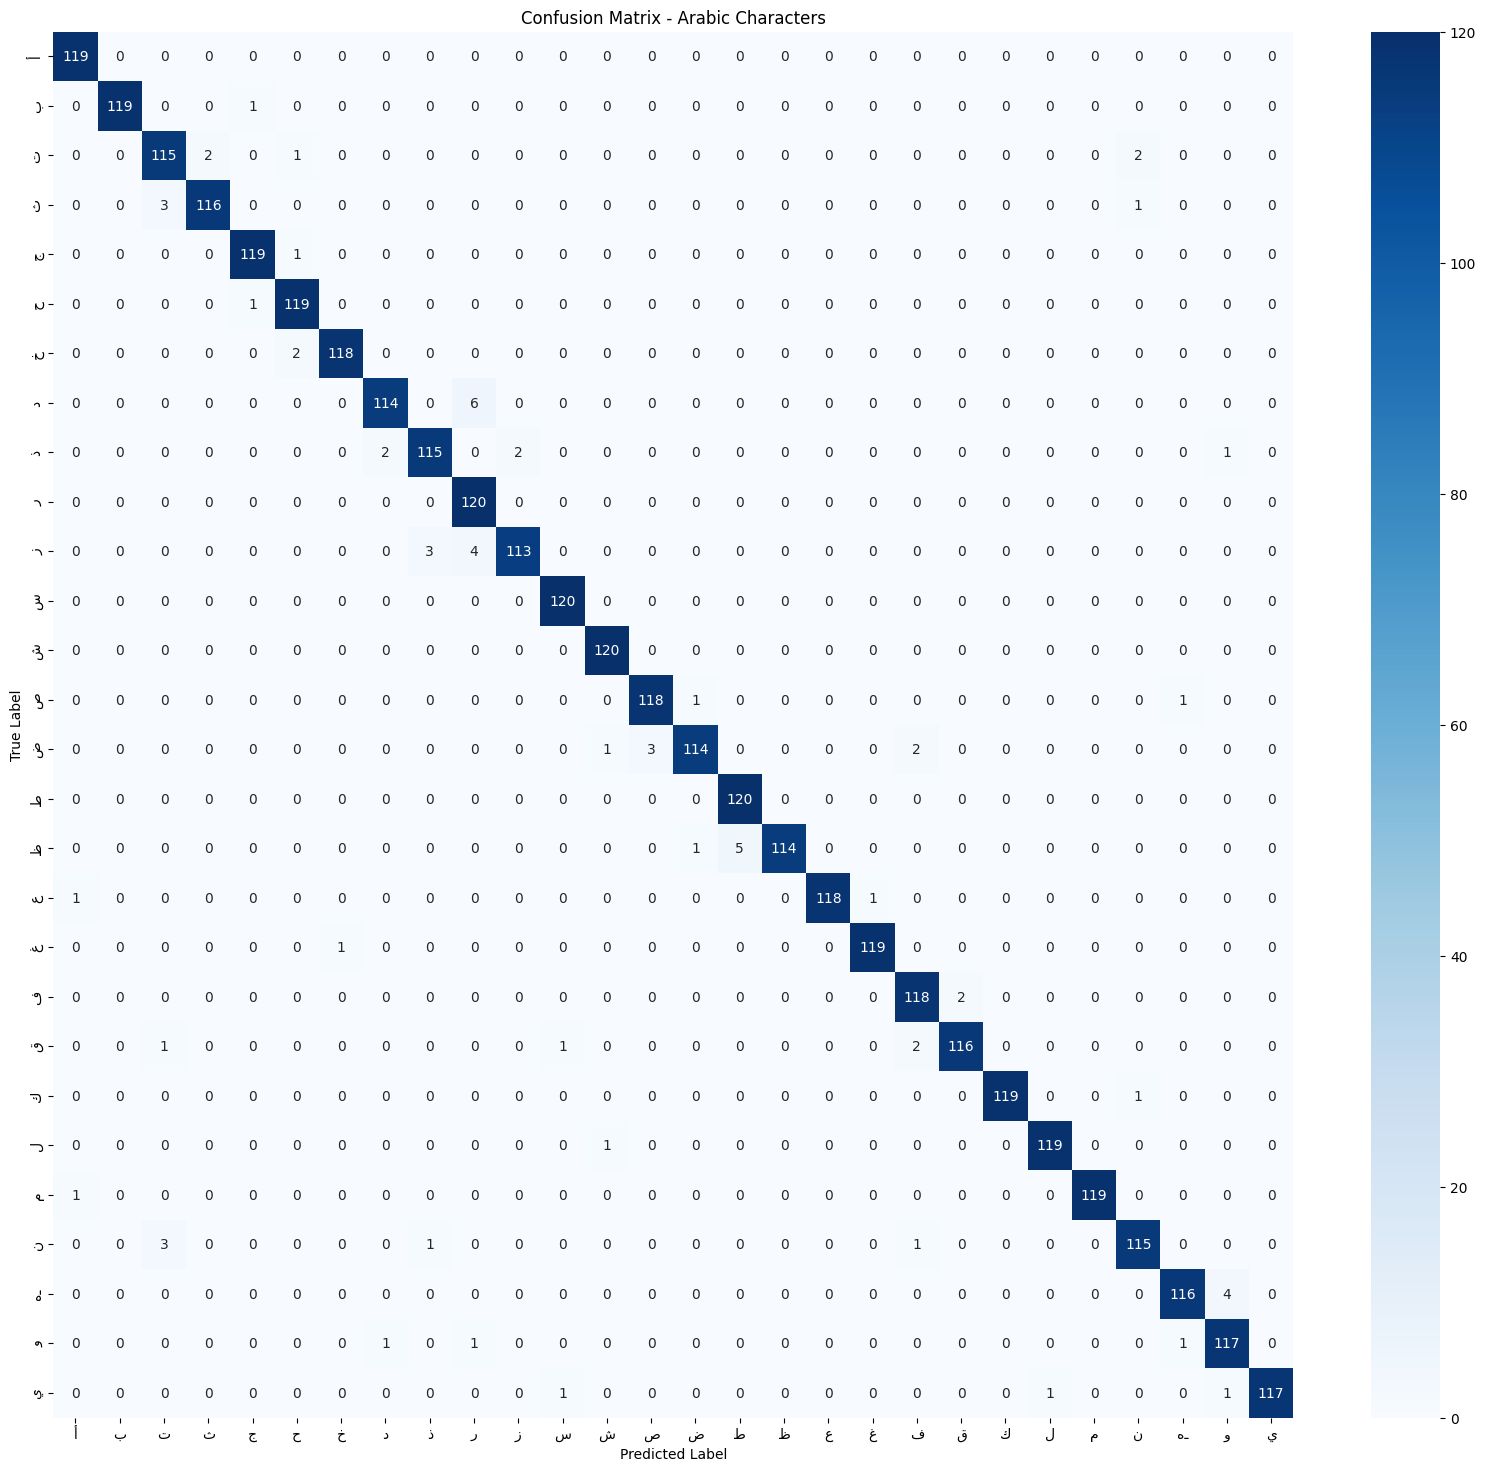

In [20]:
# Confusion Matrix 
cm = confusion_matrix(Y_test, Y_pred_classes)
plt.figure(figsize=(20, 18))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Confusion Matrix - Arabic Characters')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

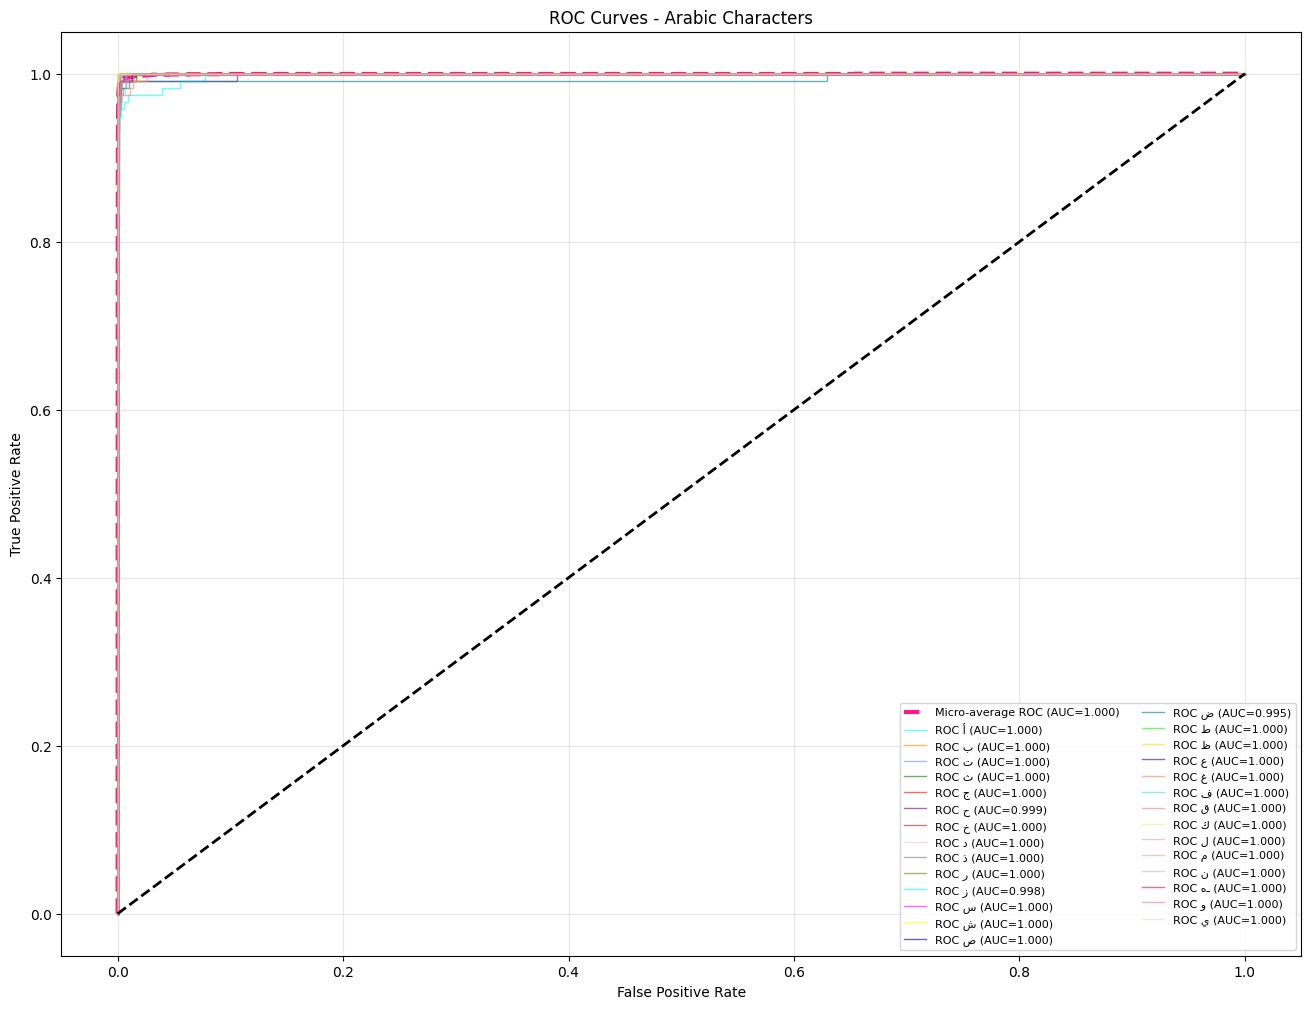

In [23]:
# ROC & AUC
Y_test_bin = label_binarize(Y_test, classes=range(num_classes))

fpr, tpr, roc_auc = {}, {}, {}
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(Y_test_bin[:, i], Y_pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

fpr["micro"], tpr["micro"], _ = roc_curve(Y_test_bin.ravel(), Y_pred_probs.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

plt.figure(figsize=(16, 12))
plt.plot(fpr["micro"], tpr["micro"],
         label=f'Micro-average ROC (AUC={roc_auc["micro"]:.3f})',
         color='deeppink', linestyle='--', linewidth=3)

colors = cycle(['aqua','darkorange','cornflowerblue','green','red','purple',
                'brown','pink','gray','olive','cyan','magenta','yellow',
                'navy','teal','lime','gold','indigo','coral','turquoise',
                'salmon','khaki','plum','tan','silver','crimson','orchid','wheat'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=1, alpha=0.6,
             label=f'ROC {class_names[i]} (AUC={roc_auc[i]:.3f})')

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - Arabic Characters')
plt.legend(loc="lower right", fontsize=8, ncol=2)
plt.grid(True, alpha=0.3)
plt.show()


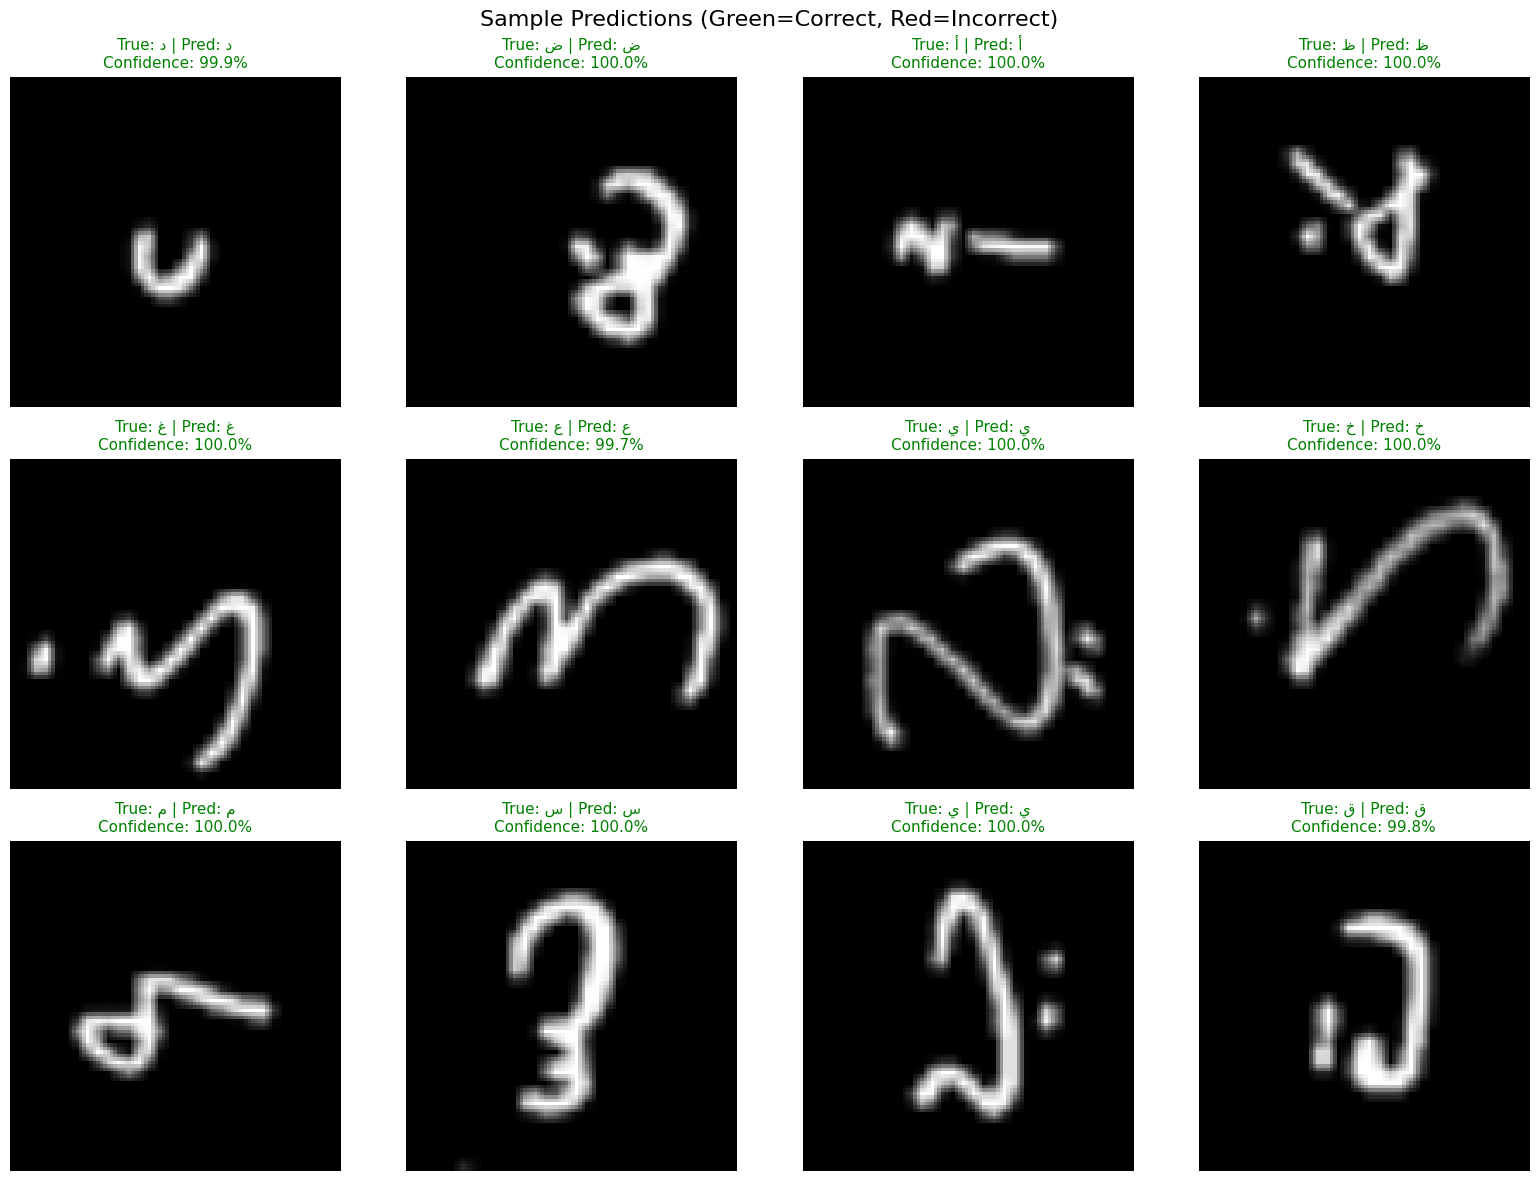

In [24]:
# Sample Predictions 
n_samples = 12
indices = np.random.choice(len(X_test), n_samples, replace=False)
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
axes = axes.ravel()

for i, idx in enumerate(indices):
    axes[i].imshow(X_test[idx].squeeze(), cmap='gray')
    true_label = class_names[Y_test[idx]]
    pred_label = class_names[Y_pred_classes[idx]]
    confidence = Y_pred_probs[idx][Y_pred_classes[idx]] * 100
    color = 'green' if Y_test[idx] == Y_pred_classes[idx] else 'red'
    axes[i].set_title(f'True: {true_label} | Pred: {pred_label}\nConfidence: {confidence:.1f}%',
                      color=color, fontsize=11)
    axes[i].axis('off')

plt.suptitle('Sample Predictions (Green=Correct, Red=Incorrect)', fontsize=16)
plt.tight_layout()
plt.show()